                                                file  \
0  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...   
1  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...   
2  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...   
3  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...   
4  CWE121_Stack_Based_Buffer_Overflow__CWE129_ran...   

                                            function          status tool  \
0  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...   true_positive  ast   
1  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...  false_positive  ast   
2  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...   true_positive  ast   
3  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...  false_positive  ast   
4  CWE121_Stack_Based_Buffer_Overflow__CWE129_ran...   true_positive  ast   

      cwe info  
0  CWE121  NaN  
1  CWE121  NaN  
2  CWE121  NaN  
3  CWE121  NaN  
4  CWE121  NaN  


<Figure size 1296x720 with 0 Axes>

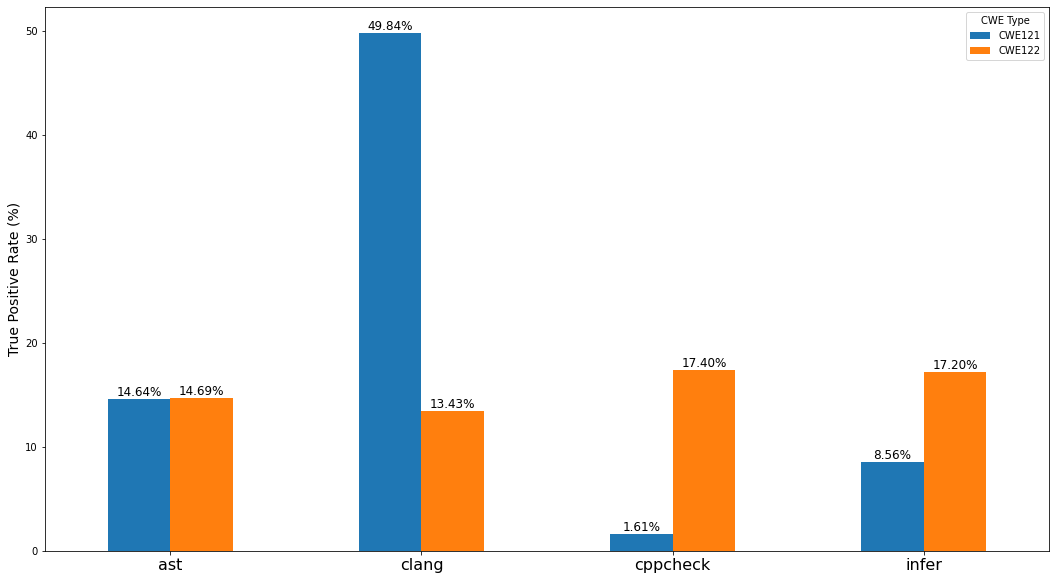

<Figure size 1296x720 with 0 Axes>

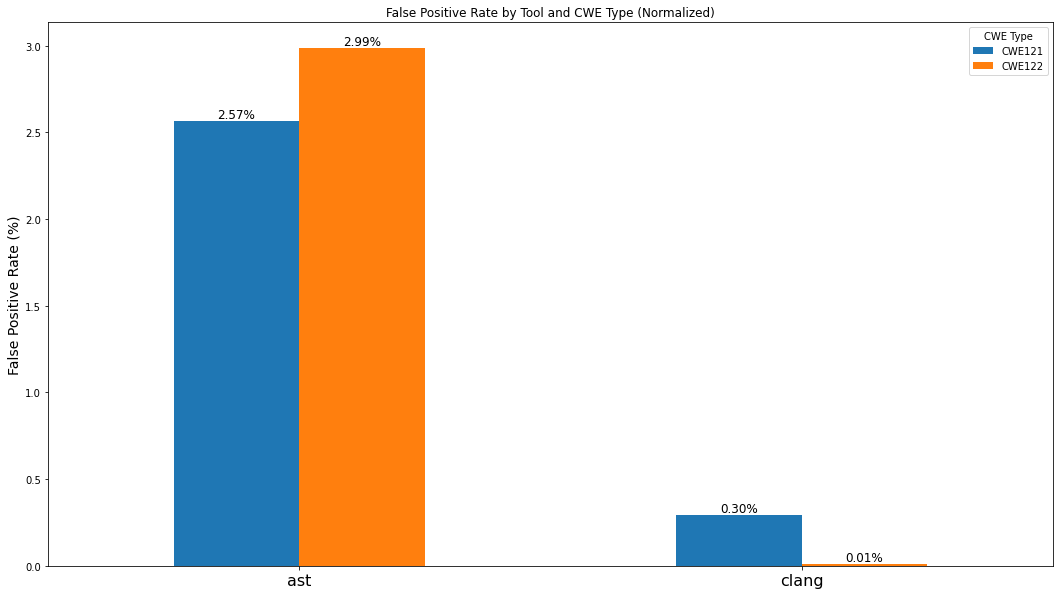

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from venny4py.venny4py import *

# Directory containing the results
RESULTS_PATH = os.path.join(Path.cwd().parent, 'results')

# Tools and CWE types
tools = ['ast', 'clang', 'cppcheck', 'infer']
cwe_types = ['CWE121', 'CWE122']
labels = {
    'ast': 'AST Insight',
    'infer': 'FB Infer',
    'cppcheck': 'CPP Check',
    'clang': 'Clang SA'
}

# Load the counts of good and bad test cases for each CWE
test_case_counts = {}
for cwe in cwe_types:
    test_case_counts_path = os.path.join(RESULTS_PATH, f'{cwe}_test_count.json')
    with open(test_case_counts_path, 'r') as file:
        test_case_counts[cwe] = json.load(file)

# Combine JSON data into a single DataFrame
all_data = []

for tool in tools:
    for cwe in cwe_types:
        file_path = os.path.join(RESULTS_PATH, f'{cwe}_{tool}_results.json')
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                data = json.load(file)
                for entry in data:
                    entry['tool'] = tool
                    entry['cwe'] = cwe
                    all_data.append(entry)

df = pd.DataFrame(all_data)

# Check the structure of the DataFrame
print(df.head())

# Filter for true positives and false positives
true_positives = df[df['status'] == 'true_positive']
false_positives = df[df['status'] == 'false_positive']

# Count the occurrences of each status for each tool and CWE type
tp_counts = true_positives.groupby(['tool', 'cwe']).size().unstack().fillna(0)
fp_counts = false_positives.groupby(['tool', 'cwe']).size().unstack().fillna(0)

# Normalize true positives by the number of bad cases and false positives by the number of good cases
tp_normalized = tp_counts.copy()
fp_normalized = fp_counts.copy()

for cwe in cwe_types:
    tp_normalized[cwe] = tp_normalized[cwe] / test_case_counts[cwe]['bad_count'] * 100
    fp_normalized[cwe] = fp_normalized[cwe] / test_case_counts[cwe]['good_count'] * 100

# Increase the figure size for better readability
plt.figure(figsize=(18, 10))  # Increased figure size
ax = tp_normalized.plot(kind='bar', figsize=(18, 10))  # Apply the figure size to the plot
plt.title('')
plt.xlabel('')
plt.ylabel('True Positive Rate (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=16)
plt.legend(title='CWE Type')

# Add the values on top of each bar with increased text size and percent sign
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=12)
    

plt.savefig('true_positives.jpg',bbox_inches='tight', dpi=150)
plt.show()

# Increase the figure size for false positives
plt.figure(figsize=(18, 10))  # Increased figure size
ax = fp_normalized.plot(kind='bar', figsize=(18, 10))  # Apply the figure size to the plot
plt.title('False Positive Rate by Tool and CWE Type (Normalized)')
plt.xlabel('')
plt.ylabel('False Positive Rate (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=16)
plt.legend(title='CWE Type')

# Add the values on top of each bar with increased text size and percent sign
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge', fontsize=12)
    
    

plt.savefig('false_positives.jpg',bbox_inches='tight', dpi=150)
plt.show()


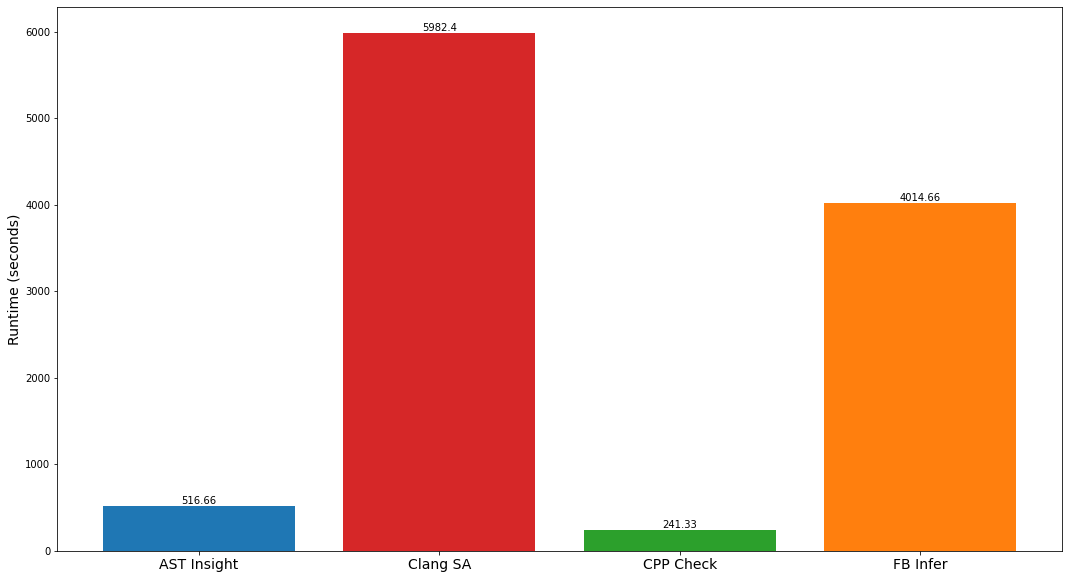

In [3]:
# Colors for each tool
tool_colors = {
    'ast': '#1f77b4',
    'clang': '#d62728',
    'cppcheck': '#2ca02c',
    'infer': '#ff7f0e'
}

# Collect runtime data
runtime_data = []

for tool in tools:
    file_path = os.path.join(RESULTS_PATH, f'{tool}_runtime_and_memory.json')
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            data = json.load(file)
            runtime_data.append({
                'tool': labels[tool], 
                'runtime': data['runtime'],
                'color': tool_colors[tool]
            })

# Convert to DataFrame
df = pd.DataFrame(runtime_data)

# Plot the runtime results
plt.figure(figsize=(18, 10))
bars = plt.bar(df['tool'], df['runtime'], color=df['color'])
plt.title('')
plt.xlabel('')
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.xticks(rotation=0, fontsize=14)

# Add runtime values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

plt.savefig('runtime.jpg',bbox_inches='tight', dpi=150)
plt.show()

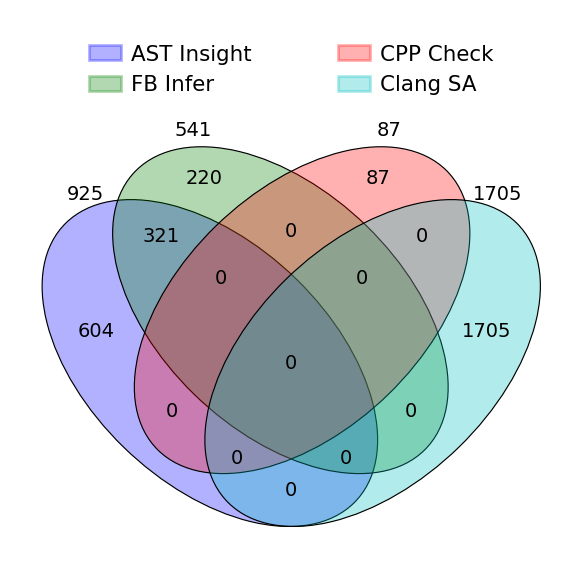

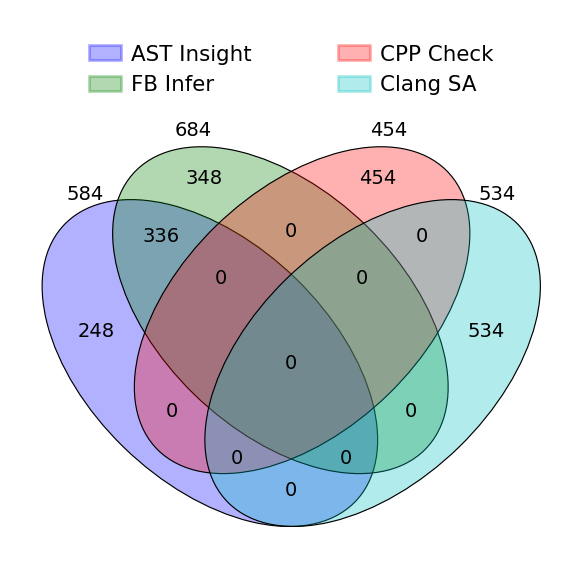

In [4]:
def load_true_positives(tool, cwe):
    file_path = os.path.join(RESULTS_PATH, f'{cwe}_{tool}_results.json')
    true_positives = set()
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            data = json.load(file)
            true_positives = {(entry['file'], entry['function']) for entry in data if entry['status'] == 'true_positive'}
    return true_positives

# Prepare data for Venny4Py
def prepare_venn_data(cwe):
    ast_tp = load_true_positives('ast', cwe)
    infer_tp = load_true_positives('infer', cwe)
    clang_tp = load_true_positives('clang', cwe)
    cppcheck_tp = load_true_positives('cppcheck', cwe)

    venn_data = {
        labels['ast']: ast_tp,
        labels['infer']: infer_tp,
        labels['cppcheck']: cppcheck_tp,
        labels['clang']: clang_tp
    }
    
    return venn_data



# Generate Venn diagram for CWE121
venn_data_cwe121 = prepare_venn_data('CWE121')
venny4py(sets=venn_data_cwe121, out='VennCWE121')

# Generate Venn diagram for CWE122
venn_data_cwe122 = prepare_venn_data('CWE122')
venny4py(sets=venn_data_cwe122, out='VennCWE122')